<a href="https://colab.research.google.com/github/Nethmi-Randi/AudioVideoSentimentAnalysis/blob/main/audioSentimentAnalysisModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/ravdess.zip'

import zipfile
extract_dir = '/content/MyDrive/RAVDESS/ravdess'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Process and Organize the dataset and Create data frames

In [ ]:
import os
import pandas as pd

Ravdess = '/content/MyDrive/RAVDESS/ravdess/ravdess'

ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

emotion_map = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}
ravdess_df.Emotions.replace(emotion_map, inplace=True)

# Filter out 'calm' emotion
ravdess_df = ravdess_df[ravdess_df.Emotions != 'calm']

print(ravdess_df.head())


  Emotions                                               Path
0     fear  /content/MyDrive/RAVDESS/ravdess/ravdess/Actor...
1     fear  /content/MyDrive/RAVDESS/ravdess/ravdess/Actor...
2     fear  /content/MyDrive/RAVDESS/ravdess/ravdess/Actor...
3    happy  /content/MyDrive/RAVDESS/ravdess/ravdess/Actor...
5    happy  /content/MyDrive/RAVDESS/ravdess/ravdess/Actor...


Augmentation of audio data

In [ ]:
def noise(data): # Add random noise to the signal
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8): # Change the speed of the audio without affecting the pitch
    return librosa.effects.time_stretch(data, rate)

def shift(data): #Shift the audio signal in time
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7): #Change the pitch of the audio , without affecting the speed.
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


Extract features from audio

In [ ]:
def extract_features(data, sample_rate):
    result = np.array([])

    # Zero Crossing Rate - The rate at which the signal changes from positive to negative or vice versa
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(data)) #Short-Time Fourier Transform of the audio signal
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0) #computes the chromagram from the STFT
    result = np.hstack((result, chroma_stft))

    # MFCC - Coefficients that represent the short-term power spectrum of the sound
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value - square root of the average power of the audio signal
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram- spectrogram where the frequencies are converted to the Mel scale
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result


In [ ]:
pip install resampy

In [ ]:
!pip install librosa resampy
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!sudo apt-get install libfluidsynth3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libinstpatch-1.0-2 timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gm
The following NEW packages will be installed:
  libfluidsynth3 libinstpatch-1.0-2 timgm6mb-soundfont
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,913 kB of archives.
After this operation, 7,661 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libinstpatch-1.0-2 amd64 1.1.6-1 [240 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 timgm6mb-soundfont all 1.3-5 [5,427 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libfluidsynth3 amd64 2.2.5-1 [246 kB]
Fetched 5,913 kB in 2s (3,236 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [ ]:
!pip install cartopy
import cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.1 MB/s eta 0:00:00


In [ ]:
!pip install resampy

In [ ]:
!pip install librosa --upgrade

In [ ]:
!pip install llvmlite==0.31.0

!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llvmlite
  Running setup.py clean for llvmlite
Failed to build llvmlite
ERROR: Could not build wheels for llvmlite, which is required to install pyproject.toml-based projects


In [ ]:
!pip3 install resampy

In [ ]:
!pip install resampy

In [ ]:
!pip install librosa==0.9.2

In [ ]:
import librosa
import soundfile as sf
import numpy as np

In [ ]:
librosa.__version__

'0.9.2'

Prepare Audio data


In [ ]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# lists to hold features and labels
x, y = [], []

# Iterate over the dataframe to extract features
for path, emotion in zip(ravdess_df.Path, ravdess_df.Emotions):
    data, sample_rate = librosa.load(path, res_type='kaiser_fast')

    features = extract_features(data, sample_rate)

    x.append(features)
    y.append(emotion)

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Normalize the feature data
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Split the dataset into training and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, BatchNormalization

# Define input shape
input_shape = (x_train.shape[1], 1)

# Initialize the model
model = Sequential()

# Convolutional layers
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Flatten())

# Dense layers
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=7, activation='softmax'))


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=32, epochs=75, validation_data=(x_val, y_val), callbacks=[rlrp])

Epoch 1/75
179/179 [==============================] - 40s 127ms/step - loss: 2.0537 - accuracy: 0.2181 - val_loss: 1.8288 - val_accuracy: 0.2514
Epoch 2/75
179/179 [==============================] - 21s 118ms/step - loss: 1.8632 - accuracy: 0.2509 - val_loss: 1.8061 - val_accuracy: 0.2514
Epoch 3/75
179/179 [==============================] - 21s 118ms/step - loss: 1.7632 - accuracy: 0.3098 - val_loss: 1.9136 - val_accuracy: 0.2804
Epoch 4/75
179/179 [==============================] - 21s 119ms/step - loss: 1.5877 - accuracy: 0.3922 - val_loss: 2.0243 - val_accuracy: 0.2937
Epoch 5/75
179/179 [==============================] - 21s 116ms/step - loss: 1.4798 - accuracy: 0.4327 - val_loss: 1.6411 - val_accuracy: 0.3562
Epoch 6/75
179/179 [==============================] - 21s 118ms/step - loss: 1.3917 - accuracy: 0.4688 - val_loss: 1.6003 - val_accuracy: 0.3540
Epoch 7/75
179/179 [==============================] - 22s 120ms/step - loss: 1.3148 - accuracy: 0.4973 - val_loss: 1.5474 - val_ac

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/models/mau.h5')

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
import os

# Mount Google Drive
drive.mount('/content/drive')
# Load the saved model
model_path = '/content/drive/MyDrive/models/mau.h5'
loaded_model = load_model(model_path)
print("Model loaded from Google Drive.")

Mounted at /content/drive
Model loaded from Google Drive.


Get model Summary

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')
model_path = '/content/drive/My Drive/models/mau.h5'
model = load_model(model_path)
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 182, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 91, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 91, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 46, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 46, 128)           16

Model Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

loss, accuracy = loaded_model.evaluate(x_test, y_test)

y_pred = loaded_model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Test Loss: 2.2512
Test Accuracy: 62.23%
113/113 [==============================] - 3s 25ms/step
Precision: 0.6226
Recall: 0.6223
F1 Score: 0.6208


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
8/8 [==============================] - 1s 90ms/step


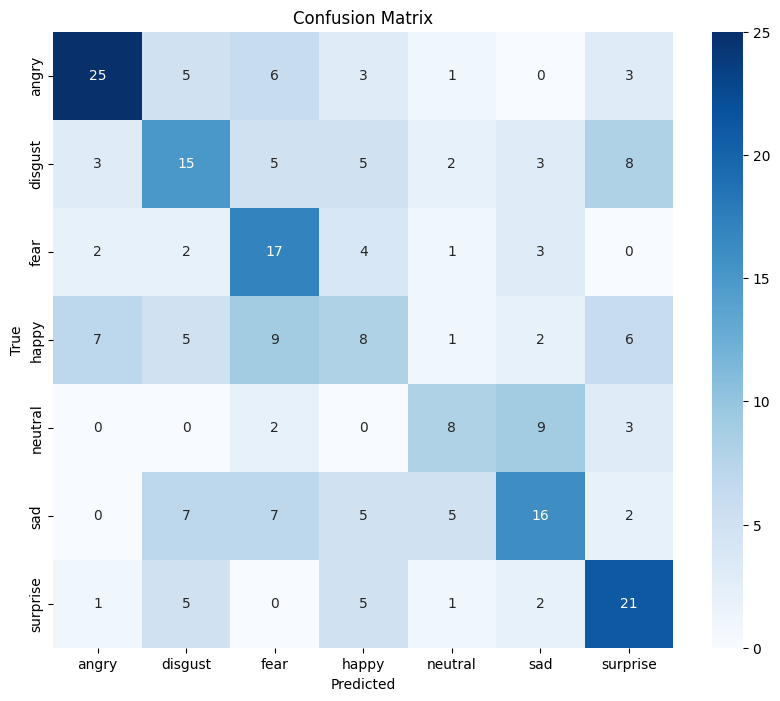

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

model_path = '/content/drive/My Drive/model/mau.h5'

model = load_model(model_path)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




Create Scaler file

In [ ]:

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
import pickle

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive containing only audio files
zip_file_path = '/content/drive/MyDrive/ravdess.zip'
import zipfile

# Directory to extract the audio dataset
extract_dir = '/content/MyDrive/RAVDESS/ravdess'
# Unzip the audio dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Directory to the audio dataset
Ravdess = '/content/MyDrive/RAVDESS/ravdess/ravdess'

# List directories and files
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

# Extract emotions and file paths
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# Create DataFrames
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map emotions to their respective labels
emotion_map = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}
ravdess_df.Emotions.replace(emotion_map, inplace=True)

# Filter out 'calm' emotion
ravdess_df = ravdess_df[ravdess_df.Emotions != 'calm']

def extract_features(data, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result


x, y = [], []

for path, emotion in zip(ravdess_df.Path, ravdess_df.Emotions):
    data, sample_rate = librosa.load(path, res_type='kaiser_fast')

    features = extract_features(data, sample_rate)

    x.append(features)
    y.append(emotion)

x = np.array(x)
y = np.array(y)

# Normalize the feature data
scaler = StandardScaler()
x = scaler.fit_transform(x)

scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f'Scaler saved to {scaler_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Scaler saved to /content/drive/MyDrive/audio_scaler.pkl


Test the model


In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')
model_path = '/content/drive/My Drive/models/mau.h5'
model = load_model(model_path)

Mounted at /content/drive


In [ ]:
#testing
import os
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import pickle
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

# Path to the trained model and scaler
model_path = '/content/drive/MyDrive/models/mau.h5'
scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'

# Load the trained classifier
def load_classifier(model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    classifier = load_model(model_path)
    return scaler, classifier

# Extract audio features by segment
def extract_features_segment(audio_segment, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(audio_segment))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=audio_segment).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_segment, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Predict sentiment
def predict_sentiment(audio_file, scaler, classifier, sample_rate=22050):

    emotions = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    segments = librosa.effects.split(audio, top_db=20)
    segment_sentiments = []
    overall_sentiments = []

    for start, end in segments:
        start_ms = int((start / sample_rate) * 1000)
        end_ms = int((end / sample_rate) * 1000)
        segment = audio[start:end]
        features = extract_features_segment(segment, sample_rate)

        features_scaled = scaler.transform(features.reshape(1, -1))
        sentiment = classifier.predict(features_scaled)[0]
        sentiment_label = emotions[np.argmax(sentiment)]
        segment_sentiments.append((start_ms, end_ms, sentiment_label))

    if segment_sentiments:
        current_start, current_end, current_sentiment = segment_sentiments[0]
        for next_start, next_end, next_sentiment in segment_sentiments[1:]:
            if next_sentiment == current_sentiment:
                current_end = next_end
            else:
                overall_sentiments.append((current_start, current_end, current_sentiment))
                current_start, current_end, current_sentiment = next_start, next_end, next_sentiment
        overall_sentiments.append((current_start, current_end, current_sentiment))

    return overall_sentiments

scaler, classifier = load_classifier(model_path, scaler_path)
audio_file_path = '/content/drive/MyDrive/AudioData/disgust/03-01-07-01-01-01-11.wav'
sentiments = predict_sentiment(audio_file_path, scaler, classifier)
print(sentiments)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 32ms/step
[(1044, 2275, 'angry'), (2321, 2693, 'disgust')]


Get the sentiment of audio in frame wise

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import pickle
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/models/mau.h5'
scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'

# Load the trained classifier
def load_classifier(model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    classifier = load_model(model_path)
    return scaler, classifier

# Extract audio features by segment
def extract_features_segment(audio_segment, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(audio_segment))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=audio_segment).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_segment, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Predict sentiment
def predict_sentiment(audio_file, scaler, classifier, sample_rate=22050):
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    duration = librosa.get_duration(y=audio, sr=sample_rate)
    total_seconds = int(np.ceil(duration))
    sentiments = []

    for second in range(total_seconds):
        start_sample = second * sample_rate
        end_sample = start_sample + sample_rate

        if end_sample > len(audio):
            end_sample = len(audio)

        segment = audio[start_sample:end_sample]

        if len(segment) > 0:
            features = extract_features_segment(segment, sample_rate)
            features_scaled = scaler.transform(features.reshape(1, -1))
            sentiment = classifier.predict(features_scaled)[0]
            sentiment_label = emotions[np.argmax(sentiment)]
        else:
            sentiment_label = None

        sentiments.append(sentiment_label)

    return sentiments, duration

# Load classifier and scaler
scaler, classifier = load_classifier(model_path, scaler_path)

# Path to the audio file in your Google Drive
audio_file_path = '/content/drive/MyDrive/AudioData/disgust/03-01-07-01-01-01-11.wav'

# Predict sentiments
sentiments, duration = predict_sentiment(audio_file_path, scaler, classifier)

# Print results
print("Duration of the audio file:", duration, "seconds")
print("Sentiments:", sentiments)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 29ms/step
Duration of the audio file: 3.670340136054422 seconds
Sentiments: ['disgust', 'angry', 'disgust', 'disgust']


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to the trained model and scaler
model_path = '/content/drive/MyDrive/models/mau.h5'
scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'

# Load the trained classifier
def load_classifier(model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    classifier = load_model(model_path)
    return scaler, classifier

# Extract audio features by segment
def extract_features_segment(audio_segment, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(audio_segment))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=audio_segment).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_segment, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Predict sentiment
def predict_sentiment(audio_file, scaler, classifier, sample_rate=22050):
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    duration = librosa.get_duration(y=audio, sr=sample_rate)
    total_seconds = int(np.ceil(duration))
    sentiments = []

    previous_sentiment_label = None

    for second in range(total_seconds):
        start_sample = second * sample_rate
        end_sample = start_sample + sample_rate

        if end_sample > len(audio):
            end_sample = len(audio)

        segment = audio[start_sample:end_sample]

        if len(segment) > 0:
            features = extract_features_segment(segment, sample_rate)
            features_scaled = scaler.transform(features.reshape(1, -1))
            sentiment = classifier.predict(features_scaled)[0]
            sentiment_label = emotions[np.argmax(sentiment)]
            previous_sentiment_label = sentiment_label
        else:
            sentiment_label = previous_sentiment_label

        sentiments.append(sentiment_label)

    return sentiments, duration

# Load classifier and scaler
scaler, classifier = load_classifier(model_path, scaler_path)

# Path to the audio file in your Google Drive
audio_file_path = '/content/drive/MyDrive/AudioData/disgust/03-01-07-01-01-01-11.wav'

# Predict sentiments
sentiments, duration = predict_sentiment(audio_file_path, scaler, classifier)

# Print results
print("Duration of the audio file:", duration, "seconds")
print("Sentiments:", sentiments)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 0s 32ms/step
Duration of the audio file: 3.670340136054422 seconds
Sentiments: ['disgust', 'angry', 'disgust', 'disgust']
